In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from pycombat import pycombat


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
file_path = 'raw_data_phase_1_07_26_2024 (3).csv'  

df = pd.read_csv(file_path)


In [8]:
def feature(hdata, target_column='plate'):
    """
    Function to compute accuracy and MCC for a given dataset.
    
    Args:
        df (pd.DataFrame): Input dataset.
        target_column (str): Column to use as the target variable (default: 'plate').

    Returns:
        dict: Dictionary with Accuracy and MCC metrics.
    """   
    # Define time and response columns
    time_columns = [f'elapsed_time_{i}' for i in range(2, 82)]
    response_columns = [f'y2_{i}' for i in range(1, 81)]

    def compute_slope(row):
        time_values = row[time_columns].values
        y_values = row[response_columns].values.astype(float)
        mask = ~np.isnan(y_values)  # Handle missing values
        
        if mask.sum() >= 2:  # Ensure at least two valid points
            model = LinearRegression()
            model.fit(time_values[mask].reshape(-1, 1), y_values[mask])
            return model.coef_[0]
        return np.nan
    
    # Compute slope for each row
    hdata['y2_slope'] = hdata.apply(compute_slope, axis=1)

    # Compute additional features
    hdata['y2_mean'] = hdata[[f'y2_{i}' for i in range(1, 81)]].mean(axis=1)
    hdata['y2_variance'] = hdata[[f'y2_{i}' for i in range(1, 81)]].var(axis=1)
    hdata['y2_min'] = hdata[[f'y2_{i}' for i in range(1, 81)]].min(axis=1)
    hdata['y2_max'] = hdata[[f'y2_{i}' for i in range(1, 81)]].max(axis=1)

    # Target variable encoding
   # y = hdata[target_column].astype('category').cat.codes

    # Prepare feature matrix
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','plate']
    feature_df = hdata[features]
    

    psd = compute_psd_features(hdata, time_columns, response_columns)
    psd.index = feature_df.index
    X= pd.concat([feature_df,psd], axis=1)

    
    return X

In [9]:
def random_forest(train_set,test_set):
    t1=feature(train_set)
    t2=feature(test_set)
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X_train=t1[features].values
    X_test=t2[features].values
    y_train=t1['plate']
    # y_train=t1['plate'].astype('category').cat.codes
    y_test=t2['plate']

    model = RandomForestClassifier(random_state=105)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Return metrics as a dictionary
    return {"Accuracy": accuracy, "MCC": mcc}

In [10]:
import scipy.signal

def compute_psd_features(df, elapsed_time_cols, y2_cols):
    """
    Computes Power Spectral Density (PSD) features for each mutant in the dataset.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing elapsed time and y2 values for each mutant.
    elapsed_time_cols (list): List of column names corresponding to elapsed time.
    y2_cols (list): List of column names corresponding to y2 values.

    Returns:
    pd.DataFrame: DataFrame containing PSD features (Peak Frequency, Total Power, Spectral Entropy) for each mutant.
    """
    from scipy.signal import welch
    from scipy.stats import entropy

    psd_features = []

    for index, row in df.iterrows():
        # Extract elapsed time and y2 values

        elapsed_time = row[elapsed_time_cols].dropna().values.astype(float)
        y2_values = row[y2_cols].dropna().values.astype(float)

        # Compute sampling frequency (fs) dynamically
        time_diffs = np.diff(elapsed_time)
        fs = 1 / np.mean(time_diffs) if np.mean(time_diffs) > 0 else 1  # Prevent division by zero

        # Compute PSD using Welch’s method
        frequencies, psd_values = welch(y2_values, fs, nperseg=min(256, len(y2_values)))
        # frequencies, psd_values = scipy.signal.periodogram(y2_values, fs, scaling='density')

        # Extract PSD features
        peak_freq = frequencies[np.argmax(psd_values)] if len(frequencies) > 0 else 0  # Peak frequency
        psd_features.append([peak_freq])

    

    psd_df = pd.DataFrame(psd_features, columns=["Peak_Frequency"])

    return psd_df


In [287]:

classificaiton_WT(df)

Average MCC: 0.49338923522873207
Average Accuracy: 0.5143511450381679


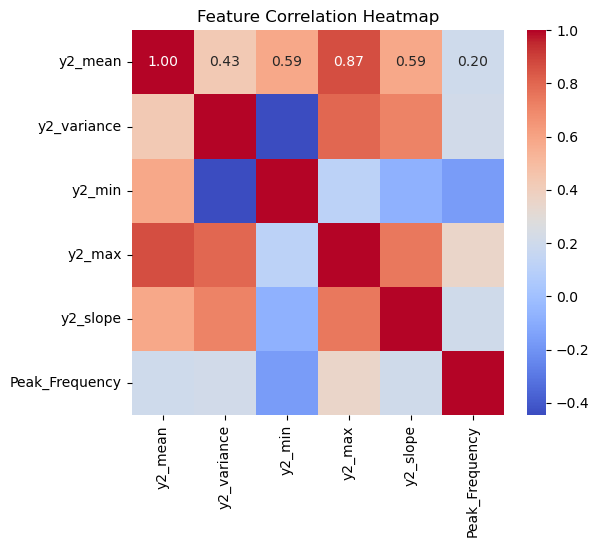

In [15]:
heatmap_plot(df)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# only for no removal
def perform_pca_and_plot(df):
    # Step 1: Select numerical features for PCA
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X = df[features].values
    y = df['plate'].values.astype(str)  
    


    #Standardize features before PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Convert results into a DataFrame
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Plate'] = y 
    print(pca_df.head())  # Debugging check

    # Plot PCA results with color-coded plates
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Plate', palette='tab10', data=pca_df, alpha=0.8) 
    plt.title("PCA Projection of Features (Colored by Plate)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Plate", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()



        PC1       PC2 Plate
0 -0.611241 -0.578455     2
1 -0.749277 -0.727584     2
2 -0.639647 -1.015087     2
3  3.942784 -1.584404     2
4  3.741674 -1.671873     2


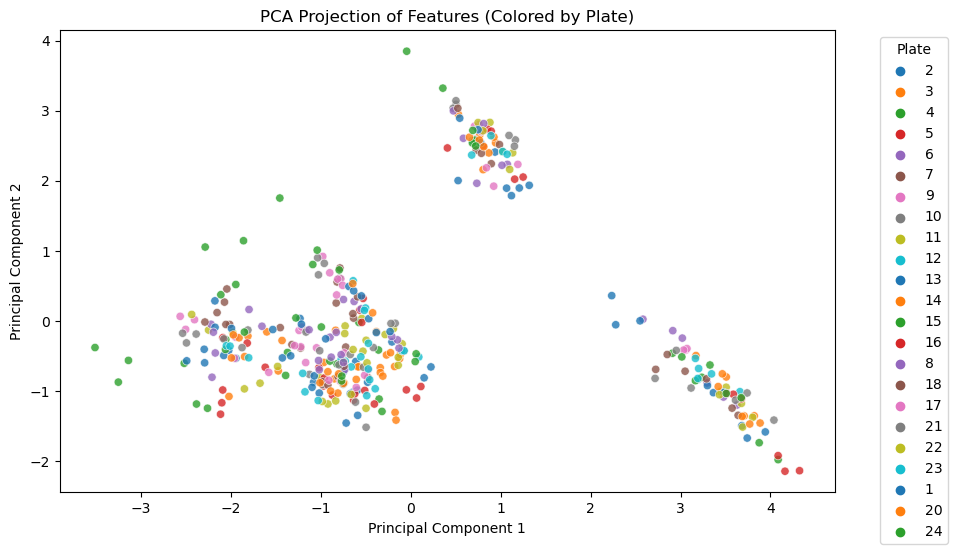

In [275]:
perform_pca_and_plot(X_original)

In [16]:
def random_forest(train_set,test_set):
    t1=feature(train_set)
    t2=feature(test_set)
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X_train=t1[features].values
    X_test=t2[features].values
    y_train=t1['plate']
    y_test=t2['plate']

    model = RandomForestClassifier(random_state=105)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Return metrics as a dictionary
    return {"Accuracy": accuracy, "MCC": mcc}

In [17]:
def split_wt_rows1(group,seed):
    wt_rows = group[group['mutant_ID'] == 'WT']

    if len(wt_rows) > 1:
        test_row = wt_rows.sample(n=1,random_state=seed)  # Randomly select one WT row for test
        train_rows = wt_rows.drop(test_row.index)  # Remaining WT rows for training
        return test_row, train_rows
    return pd.DataFrame(), pd.DataFrame()

def random_forest_result(train_set,test_set):
    t1=feature(train_set)
    t2=feature(test_set)
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X_train=t1[features].values
    X_test=t2[features].values
    y_train=t1['plate']
    y_test=t2['plate']

    model = RandomForestClassifier(random_state=105)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    

    # feature importance
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette="viridis")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Feature Importance - Random Forest")
    plt.show()


    # confusion matrix
    unique_labels = sorted(np.unique(y_test))  
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    

    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return {"Accuracy": accuracy, "MCC": mcc}
    
def result(data, num_iterations = 1):
    
    mcc_scores = []
    accuracy_scores = []

  
    for _ in range(1):
        keep_list = []
        holdout_list = []
        for plate_measure, group in data.groupby(['plate', 'light_regime']):
            if plate_measure[0] != 99:
                keep, holdout = split_wt_rows1(group,10)
                keep_list.append(keep)
                holdout_list.append(holdout)
        test_set = pd.concat(keep_list).reset_index(drop=True)
        train_set = pd.concat(holdout_list).reset_index(drop=True)


        result = random_forest_result(train_set, test_set)

    print(result)


In [261]:
data_WT=df[df['mutant_ID']=='WT']
data_WT=data_WT[data_WT['plate']!=99]


In [288]:
feature(data_WT)

,y2_mean,y2_variance,y2_min,y2_max,y2_slope,plate,Peak_Frequency
827,0.362949,0.020704,0.184086,0.537680,0.000056,2,1.993132
1099,0.364755,0.021722,0.169362,0.547512,0.000397,2,1.993132
1119,0.352185,0.022421,0.147085,0.531104,0.000501,2,1.993132
1232,0.141938,0.001437,0.091892,0.235280,-0.005191,2,0.050606
1504,0.141871,0.001507,0.086624,0.235591,-0.003998,2,0.050606
...,...,...,...,...,...,...,...
54777,0.399621,0.012329,0.269798,0.528745,0.000697,20,1.987005
55048,0.376366,0.013174,0.238018,0.513301,0.000445,20,1.987005
55091,0.428979,0.038081,0.209551,0.632449,-0.000759,1,0.998511
55092,0.412236,0.037803,0.175868,0.617467,-0.000899,1,0.998511


In [263]:
data_SVD_WT=data_SVD[data_SVD['mutant_ID']=='WT']
data_SVD_WT=data_SVD_WT[data_SVD_WT['plate']!=99]


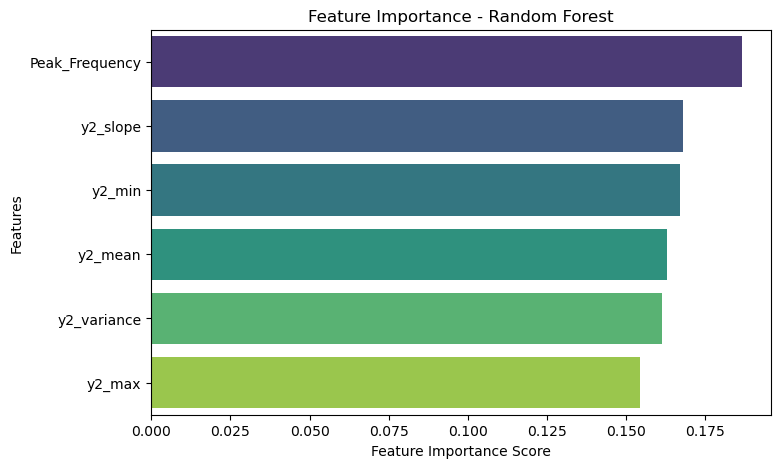

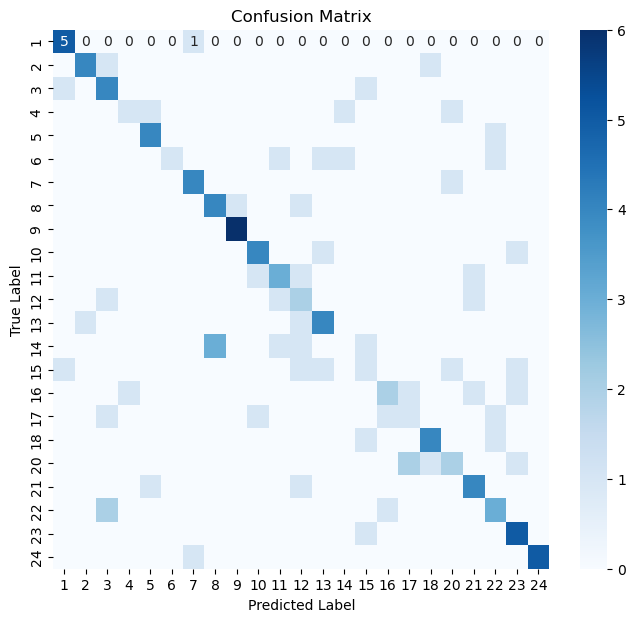

{'Accuracy': 0.5572519083969466, 'MCC': 0.5381344312510011}


In [272]:
result(df)

## SVD feature space

In [3]:
def classificaiton_WT(data, num_iterations = 100):
    
    mcc_scores = []
    accuracy_scores = []

  
    for _ in range(num_iterations):
        keep_list = []
        holdout_list = []
        for plate_measure, group in data.groupby(['plate', 'light_regime']):
            if plate_measure[0] != 99:
                keep, holdout = split_wt_rows(group)
                keep_list.append(keep)
                holdout_list.append(holdout)
        test_set = pd.concat(keep_list).reset_index(drop=True)
        train_set = pd.concat(holdout_list).reset_index(drop=True)
        result = random_forest(train_set, test_set)
        accuracy_scores.append(result["Accuracy"])
        mcc_scores.append(result["MCC"])
        
    avg_mcc = np.mean(mcc_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print("Average MCC:", avg_mcc)
    print("Average Accuracy:", avg_accuracy)



    

In [49]:

def heatmap_plot(data):
   # wt = data [data ['mutant_ID'] == 'WT'].copy()
    wt = data.copy()
    wt=wt[wt['plate']!=99]
    X=feature(wt)
    X = X.drop(columns=["plate"])
    
    
    corr_matrix = X.corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()
    return X

    

In [22]:
def perform_pca_and_plot(data):
    wt = data[data ['mutant_ID'] == 'WT'].copy()
    wt=wt[wt['plate']!=99]
    df=feature(wt)

    # Select numerical features for PCA
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X = df[features].values
    y = df['plate'].values.astype(str)  
    

    # Standardize features before PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Convert results into a DataFrame
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Plate'] = y  

    # Plot PCA results with color-coded plates
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Plate', palette='tab10', data=pca_df, alpha=0.8)  # ✅ Use 'tab10' for categorical labels
    plt.title("PCA Projection of Features (Only WT)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Plate", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [54]:
data_SVD = pd.read_csv('SVD_feature.csv')

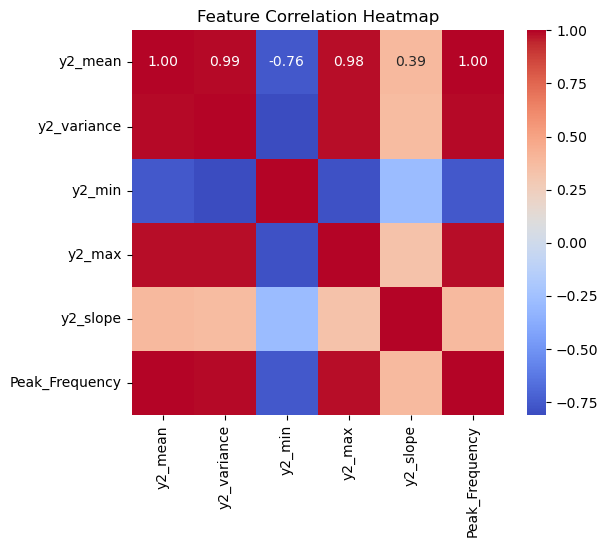

,y2_mean,y2_variance,y2_min,y2_max,y2_slope,Peak_Frequency
766,0.358305,0.013254,0.139847,0.559693,-0.000781,1.993132
767,0.359529,0.014319,0.117012,0.569141,-0.000667,1.993132
768,0.359529,0.014319,0.117012,0.569141,-0.000667,1.993132
769,0.357779,0.014124,0.076000,0.559674,-0.000859,1.993132
770,0.359029,0.012824,0.149106,0.552409,-0.000764,1.993132
...,...,...,...,...,...,...
55509,0.315727,0.004682,0.198342,0.419688,-0.001305,0.253024
55510,0.315794,0.004688,0.211852,0.415601,-0.001400,0.253024
55511,0.315813,0.004557,0.217651,0.423389,-0.001070,0.253024
55512,0.315950,0.004666,0.201210,0.415619,-0.000649,0.253024


In [55]:
heatmap_plot(data_SVD)

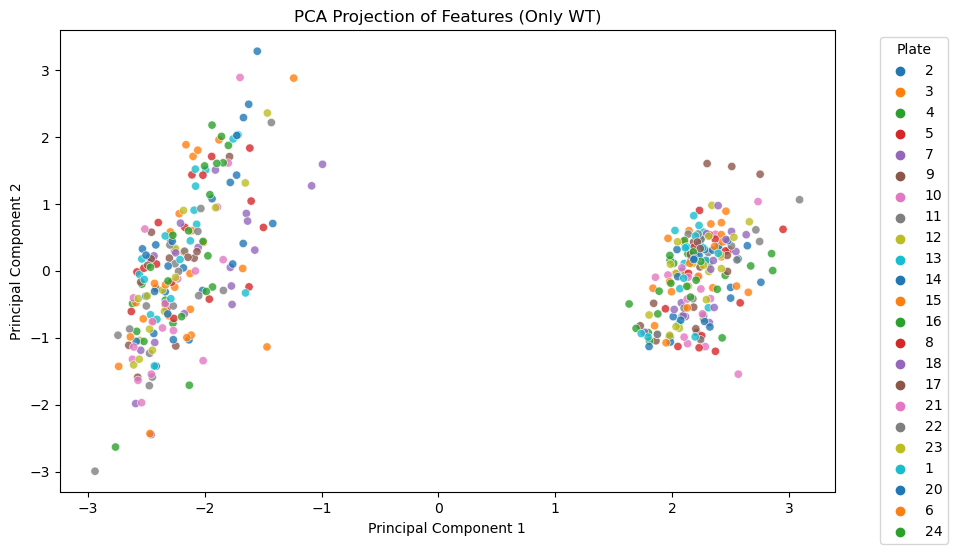

In [56]:
perform_pca_and_plot(data_SVD)

In [286]:
classificaiton_WT(data_SVD,100)

Average MCC: 0.4367166330924493
Average Accuracy: 0.46007633587786256


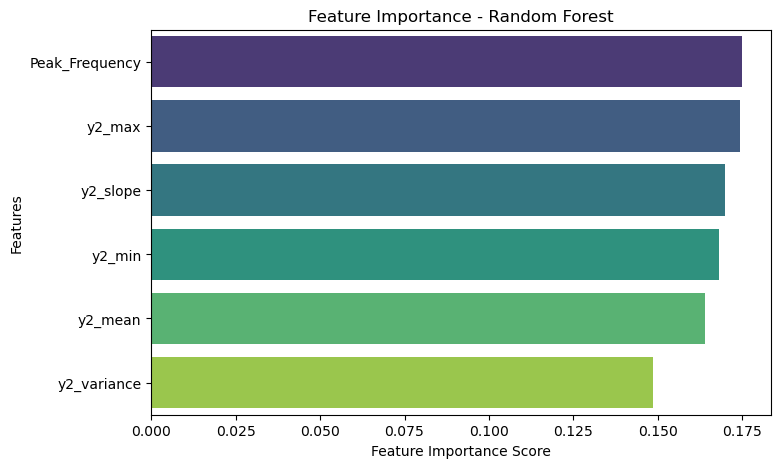

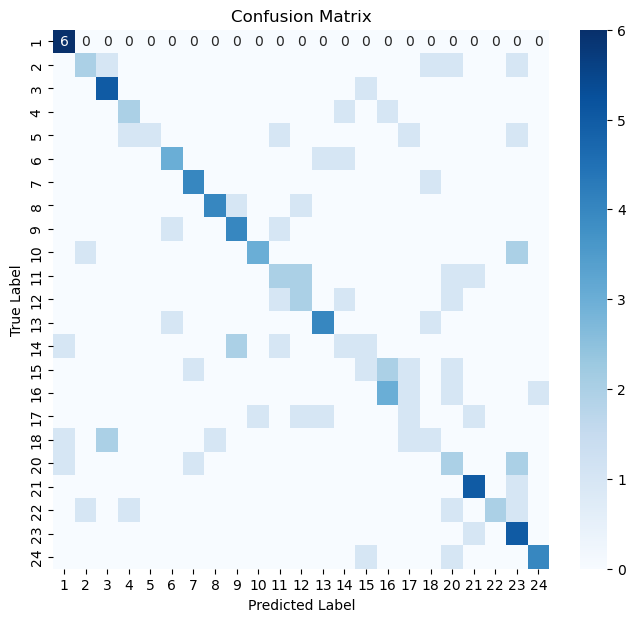

{'Accuracy': 0.5114503816793893, 'MCC': 0.4909467237427875}


In [290]:
result(data_SVD)

## Sample Space (correction only on WT)

In [58]:
data_SVD2 = pd.read_csv('SVD_sample4.csv')

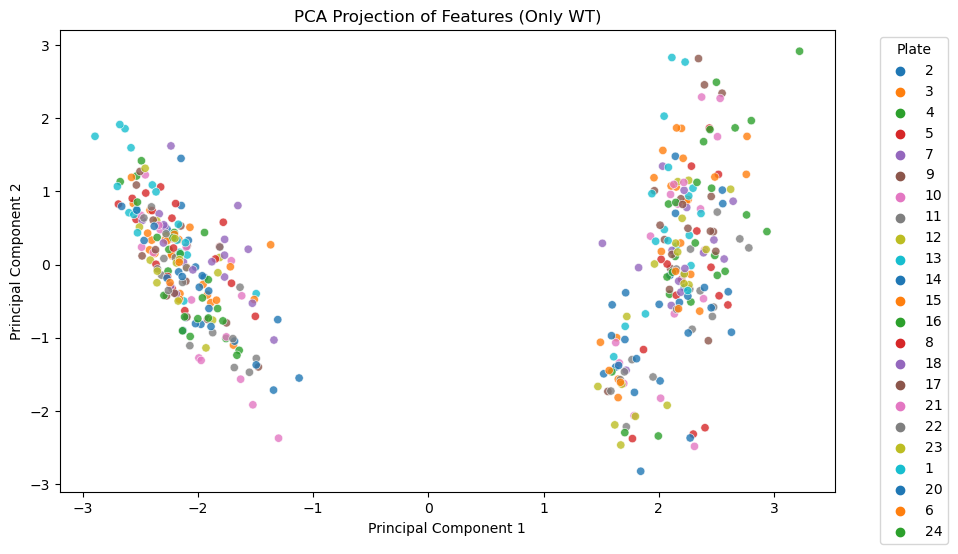

In [59]:
perform_pca_and_plot(data_SVD2)

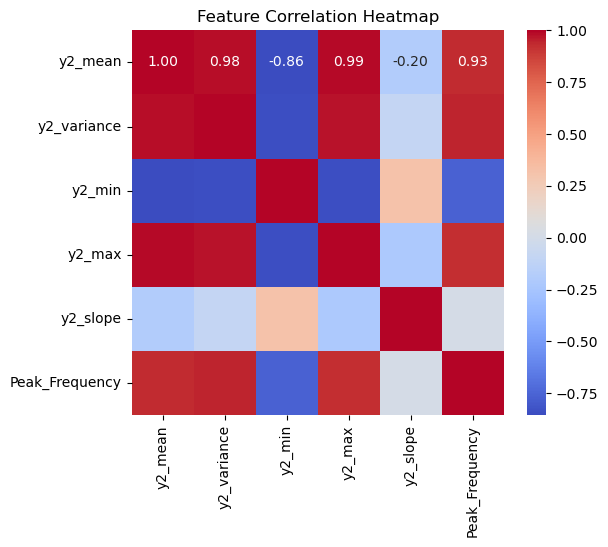

,y2_mean,y2_variance,y2_min,y2_max,y2_slope,Peak_Frequency
766,0.373962,0.014067,0.178123,0.570855,-0.000694,1.993132
767,0.376074,0.014250,0.155381,0.566223,-0.000177,1.993132
768,0.377070,0.014802,0.163328,0.575117,-0.000455,1.993132
769,0.374004,0.014534,0.175529,0.563113,-0.000302,1.989757
770,0.374208,0.014229,0.171379,0.568721,-0.000445,1.989757
...,...,...,...,...,...,...
3451,0.318584,0.005135,0.194530,0.421236,-0.001577,0.253031
3452,0.318603,0.005181,0.211122,0.420236,-0.001942,0.253031
3453,0.317892,0.005357,0.200494,0.457665,-0.002851,0.253024
3454,0.317863,0.005063,0.216332,0.445330,-0.002291,0.253024


In [61]:
heatmap_plot(data_SVD2)

In [52]:
data_SVD2.shape

(3456, 163)

In [62]:
classificaiton_WT(data_SVD2,100)

Average MCC: 0.2278217153696596
Average Accuracy: 0.26099236641221374


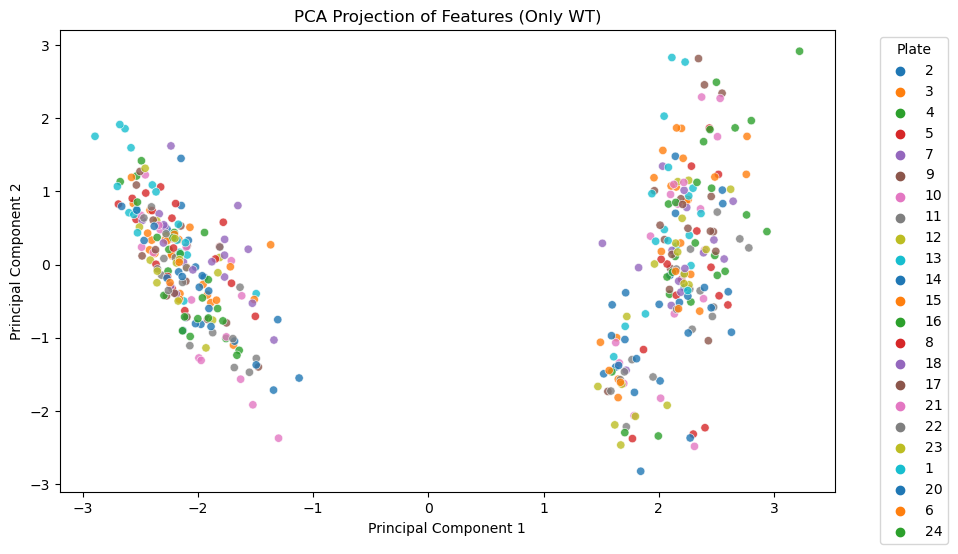

In [64]:
perform_pca_and_plot(data_SVD2)

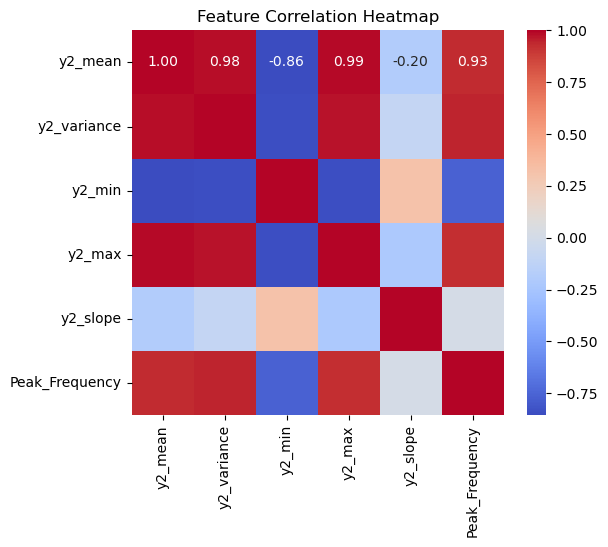

,y2_mean,y2_variance,y2_min,y2_max,y2_slope,Peak_Frequency
766,0.373962,0.014067,0.178123,0.570855,-0.000694,1.993132
767,0.376074,0.014250,0.155381,0.566223,-0.000177,1.993132
768,0.377070,0.014802,0.163328,0.575117,-0.000455,1.993132
769,0.374004,0.014534,0.175529,0.563113,-0.000302,1.989757
770,0.374208,0.014229,0.171379,0.568721,-0.000445,1.989757
...,...,...,...,...,...,...
3451,0.318584,0.005135,0.194530,0.421236,-0.001577,0.253031
3452,0.318603,0.005181,0.211122,0.420236,-0.001942,0.253031
3453,0.317892,0.005357,0.200494,0.457665,-0.002851,0.253024
3454,0.317863,0.005063,0.216332,0.445330,-0.002291,0.253024


In [65]:
heatmap_plot(data_SVD2)

## Sample Space (correction for all mutants)

In [66]:
data_SVD3 = pd.read_csv('SVD_sample_new.csv')

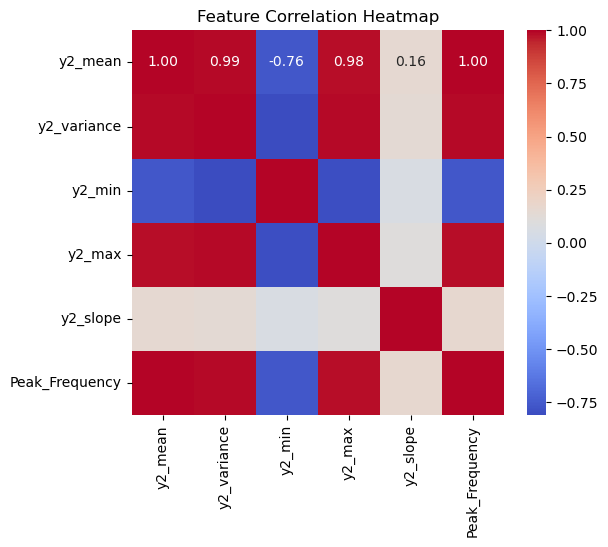

,y2_mean,y2_variance,y2_min,y2_max,y2_slope,Peak_Frequency
766,0.360655,0.013083,0.141667,0.558747,-0.000362,1.993132
767,0.355437,0.014760,0.115276,0.567088,-0.000070,1.993132
768,0.355437,0.014760,0.115276,0.567088,-0.000070,1.993132
769,0.361807,0.013730,0.083960,0.560895,-0.001199,1.993132
770,0.358820,0.013523,0.114839,0.560883,-0.005039,1.993132
...,...,...,...,...,...,...
55509,0.315749,0.004645,0.197974,0.420437,-0.001099,0.253024
55510,0.315950,0.004653,0.213214,0.412231,-0.001009,0.253024
55511,0.315835,0.004555,0.217860,0.422728,-0.001022,0.253024
55512,0.315829,0.004663,0.198530,0.418900,-0.000956,0.253024


In [67]:
heatmap_plot(data_SVD3)

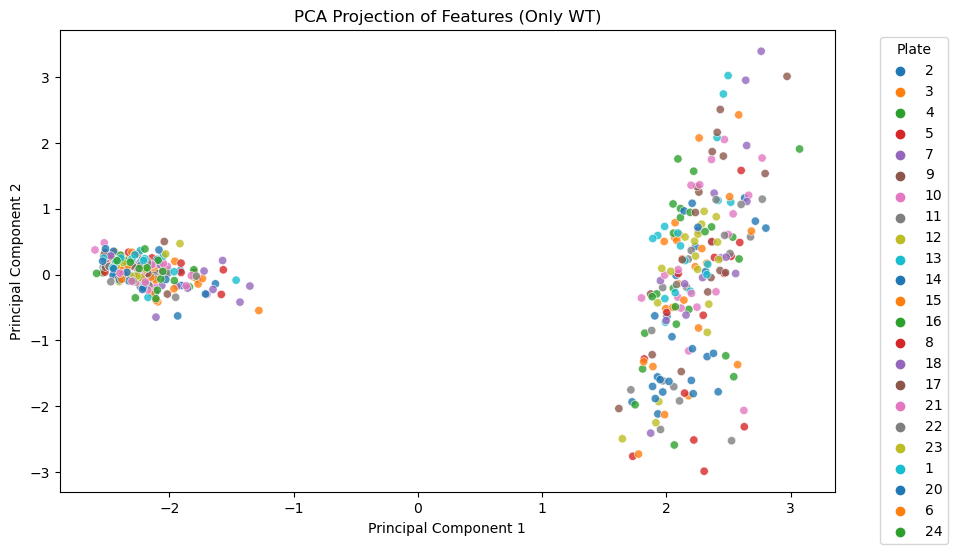

In [68]:
perform_pca_and_plot(data_SVD3)

In [69]:
classificaiton_WT(data_SVD3,100)

Average MCC: 0.16955180524746172
Average Accuracy: 0.20526717557251906


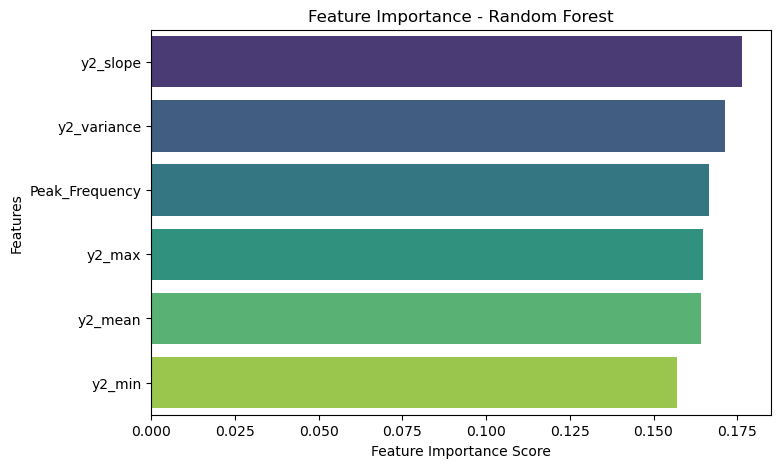

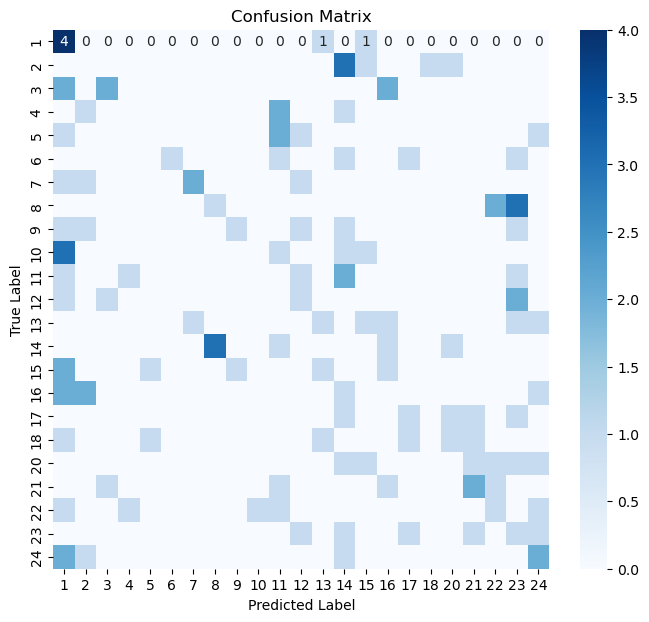

{'Accuracy': 0.15267175572519084, 'MCC': 0.11480618927549226}


In [70]:
result(data_SVD3)

## Friedman Rafsky test

In [71]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import random

def friedman_rafsky_test(features, labels, num_permutations=1000):
    """
    Perform Friedman-Rafsky test.
    
    Args:
        features (numpy.ndarray): A 2D array of feature data (rows = samples, columns = features).
        labels (list or numpy.ndarray): Group labels for each sample.
        num_permutations (int): Number of permutations for the test.
        
    Returns:
        observed_stat (int): Observed number of pure edges.
        p_value (float): P-value from the permutation test.
    """
    # Step 1: Compute the distance matrix
    dist_matrix = squareform(pdist(features, metric='euclidean'))

    # Step 2: Build the MST
    mst = minimum_spanning_tree(dist_matrix).toarray()

    # Step 3: Count pure edges in the MST
    def count_pure_edges(mst, labels):
        pure_edges = 0
        for i in range(mst.shape[0]):
            for j in range(i + 1, mst.shape[1]):
                if mst[i, j] > 0 and labels[i] == labels[j]:
                    pure_edges += 1
        return pure_edges

    observed_stat = count_pure_edges(mst, labels)

    # Step 4: Permutation Test
    permuted_stats = []
    for _ in range(num_permutations):
        permuted_labels = random.sample(labels, len(labels))
        permuted_stat = count_pure_edges(mst, permuted_labels)
        permuted_stats.append(permuted_stat)

    #print('number greater than observed',(np.sum(np.array(permuted_stats) >= observed_stat) + 1) )
    # print(permuted_stats)
    p_value = (np.sum(np.array(permuted_stats) >= observed_stat) + 1) / (num_permutations + 1)

    return observed_stat, p_value

In [72]:
# SVD
data=data_SVD1[data_SVD1['plate']!=99]
data_WT=data[data['mutant_ID']=='WT'].copy()
fea = feature(data_WT, target_column='plate')
labels=list(fea['plate'])
f = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
features=np.array(fea[f])

observed_stat, p_value = friedman_rafsky_test(features, labels, num_permutations=1000)
print(f"Observed Statistic: {observed_stat}")
print(f"P-value: {p_value}")

Observed Statistic: 29
P-value: 0.003996003996003996
